# Neural Lyapunov for a damped harmonic oscillator

In this notebook we attempt to discover a neural Lyapunov function for the damped harmonic oscillator system, which has dynamics given by
$$ \ddot{x} + 2 \zeta \omega_0 \dot{x} + \omega_0^2 x = 0, $$
where the natural frequency is $\omega_0 > 0$ and the damping constant is $\zeta > 0$.

Consider $V(x, \dot{x}) = \frac{1}{2} \dot{x}^2 + \frac{1}{2} \omega_0^2 x^2$.
Then, $V > 0 \forall x, \dot{x},$ except the fixed point at the origin, $V(0,0) = 0$, and 
$$  \begin{align*}
        \dot{V} &= \dot{x} \ddot{x} + \omega_0^2 x \dot{x}, \\
                &= \dot{x} \left( -2 \zeta \omega_0 \dot{x} - \omega_0^2 x + \omega_0^2 x \right) \\
                &= -2 \zeta \omega_0 \dot{x}^2,
    \end{align*}
$$
is nonpositive for all $(x, \dot{x})$, thus satisfying the Lyapunov condition and showing that $(x, \dot{x}) = 0$ is a stable equilibrium in the sense of Lyapunov (i.s.L.).
Additionally, since $\sqrt{x^2 + \dot{x}^2} \to \infty \implies V(x, \dot{x}) \to \infty$, LaSalle's theorem guarantees asymptotic convergence to the largest invariant set with $\dot{V} = 0$, which is just the fixed point at the origin.

We hope to find a neural network that can similarly show this equilibrium to be stable.
Note that the system is actually globally, exponentially stable, which is stronger than asymptotically stable, which is stronger than stable i.s.L.
Ability to prove these stronger versions of stability is also desirable.

# Simulation

First, let's try to just simulate a pendulum.

In [ ]:
using ModelingToolkit

In [ ]:
# Set up the ODE
@variables t x(t)
@parameters ζ ω_0
Dt = Differential(t)
DDt = Dt^2

@named damped_sho = ODESystem(DDt(x) ~ -2ζ*ω_0*Dt(x) - ω_0^2*x , t )

In [ ]:
damped_sho_simplified = structural_simplify(damped_sho)

In [ ]:
function create_dynamics_function(sys; default_params=Dict())
    sts = states(sys)
    eqs = equations(sys)
    @assert length(sts) == length(eqs) "Dynamics should be fully specified (equal number states and equations)"

    deriv = Differential(sys.iv)
    for i in 1:length(eqs)
        @assert simplify(deriv(sts[i]) == eqs[i].lhs) "Dynamics should be in state-space form"
    end

    #return build_function([eq.rhs for eq in eqs], sts) # This is close, but not quite right
    return function (state; params=Dict())
        @assert length(sts) == length(state) "Input state has wrong dimension"
        vals_dict = merge(Dict(zip(sts, state)), default_params, params)
        return [substitute(eq.rhs, vals_dict) for eq in eqs]
    end
end

In [ ]:
using DifferentialEquations

In [ ]:
prob = ODEProblem(damped_sho_simplified, [x => 1, Dt(x) => -10.0], (0.0, 25.0), [ζ => 0.1, ω_0 => 2])

In [ ]:
using Plots

In [ ]:
sol = solve(prob);

In [ ]:
plot(sol,vars=x)

# Lyapunov conditions for stability i.s.L.

For a system with dynamics $\dot{\mathbf{x}} = f(\mathbf{x})$ with a fixed point at the origin, a Lyapunov function $V(\mathbf{x})$ proves stability i.s.L. if, in some open set surrounding the origin,
$$ \begin{gather*}
    V(\mathbf{x}) \succ 0, \\
    \dot{V}(\mathbf{x}) \preceq 0.
\end{gather*}$$

There are modifications to this that can be made to ensure global, asymptotic, and/or exponential stability, but we begin with the weakest form of stability, which simplifies the set up in some ways.

# Neural Lyapunov set-up

Let the domain we consider be the box $-10 < x, \dot{x}, < 10$, which we will denote $\mathcal{D}$.
Following _Lyapunov-Net_ by Gaby et. al. 2021, we can satisfy $V(\mathbf{x}) \succ 0$ by letting,
$$ V(\mathbf{x}) = \left\lVert \phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0}) \right\rVert^2 + \delta \log(1 + \left\lVert \mathbf{x} \right\rVert^2) , $$
where $\mathbf{x} = (x, \dot{x})$ and $\delta > 0$ is a hyperparameter.
Then, $\dot{V} \preceq 0$ is a partial differential inequality given by
$$ (\nabla V) \cdot f(\mathbf{x}) \le 0.$$
(Note that $\dot{V}(\mathbf{0}) = 0$ is guaranteed by $f(\mathbf{0}) = \mathbf{0}$, which is required for the origin to be a fixed point.)
Plugging in our formula for $V$ yields
$$ \left((\nabla_\mathbf{x} \phi_\theta) (\phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0})) + \frac{(2 \delta) \mathbf{x}}{1 + \left\lVert \mathbf{x} \right\rVert^2} \right) \cdot f(\mathbf{x}) \le 0. $$
This partial differential inequality can be made into a partial differential equation using the ReLU function (though this messes with differentiability):
$$ ReLU \left(\left((\nabla_\mathbf{x} \phi_\theta) (\phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0})) + \frac{(2 \delta) \mathbf{x}}{1 + \left\lVert \mathbf{x} \right\rVert^2} \right) \cdot f(\mathbf{x}) \right) = 0. $$
Thus, a suitable loss function is
$$ \ell(\theta) = \int_{\mathbf{x} \in \mathcal{D}} ReLu \left( \left((\nabla_\mathbf{x} \phi_\theta) (\phi_\theta(\mathbf{x}) - \phi_\theta(\mathbf{0})) + \frac{(2 \delta) \mathbf{x}}{1 + \left\lVert \mathbf{x} \right\rVert^2} \right) \cdot f(\mathbf{x}) \right) d\mathbf{x}, $$
Which should achieve a minimal value of zero if and only if $\dot{V} \le 0$ for all $\mathbf{x} \in \mathcal{D}$.
(If $\phi_\theta$ isn't constrained to be continuous, then technically $\dot{V}$ could be positive on a set of measure zero, but continuity of $\phi_\theta$ implies that $\dot{V}$ cannot be positive only on a set of measure zero.)

In [1]:
using ModelingToolkit, LinearAlgebra

In [30]:
@parameters x v
@variables φ(..)
Dx = Differential(x)
Dv = Differential(v)
Dxx = Dx^2
Dvv = Dv^2

# Constants
δ = 1e-3
ζ = 0.1
ω_0 = 2.

# TODO: Can δ, ζ, and ω_0 be made into parameters?
# Making them parameters in the PDESystem and then doing the optimization
# appears to treat them as unknown parameters for which to solve. Is there
# a way to create a parameterized model where I can specify the parameters,
# like with an ODE?
#@parameters δ ζ ω_0 

# Equations
f = [  v ;
    -2ζ*ω_0*v - ω_0^2*x]
V = (φ(x,v) - φ(0.,0.)) ⋅ (φ(x,v) - φ(0.,0.)) + δ * log(1.0 + x^2 + v^2) 
DV = Symbolics.gradient(V, [x, v])
dVdt = f ⋅ DV

#eq = max(0, dVdt) ~ 0
#eq = dVdt ~ -0.1*(x^2 + v^2)
#eq = log(1.0 + exp(10.0*dVdt)) ~ 0. # Differentiable, approximate ReLU
#eq = 0 ~ max(0, 2v * ( (φ(x,v) - φ(0.,0.)) * Dx(φ(x,v)) + δ*x / (1.0 + x^2 + v^2) ) +
#                2*(-2ζ*ω_0*v - ω_0^2*x) * ((φ(x,v) - φ(0.,0.)) * Dv(φ(x,v)) + δ*v / (1.0 + x^2 + v^2)) )
#eq = 0 ~ log(1.0 + exp( 10.0 * (2v * ( (φ(x,v) - φ(0.,0.)) * Dx(φ(x,v)) + δ*x / (1.0 + x^2 + v^2) ) +
#                2*(-2ζ*ω_0*v - ω_0^2*x) * ((φ(x,v) - φ(0.,0.)) * Dv(φ(x,v)) + δ*v / (1.0 + x^2 + v^2)) )))
#eq = Dxx(φ(x,v)) + Dvv(φ(x,v)) ~ 0
eq =  -2ζ * ω_0 * v^2 ~ 2v * ( (φ(x,v) - φ(0.,0.)) * Dx(φ(x,v)) + δ*x / (1.0 + x^2 + v^2) ) +
                        2*(-2ζ*ω_0*v - ω_0^2*x) * ((φ(x,v) - φ(0.,0.)) * Dv(φ(x,v)) + δ*v / (1.0 + x^2 + v^2))

# Boundary conditions (TODO: The solver accepts this bc, but is there a better option?)
#bcs = [0.0 ~ 0.0]
#bcs = [V ~ x^2 * ω_0^2/2 + v^2/2]
bcs =  [(φ(-10.,v) - φ(0.,0.)) ⋅ (φ(-10.,v) - φ(0.,0.)) + δ * log(101. + v^2) ~ 50. * ω_0^2 + v^2/2,
        (φ( 10.,v) - φ(0.,0.)) ⋅ (φ( 10.,v) - φ(0.,0.)) + δ * log(101. + v^2) ~ 50. * ω_0^2 + v^2/2,
        (φ(x,-10.) - φ(0.,0.)) ⋅ (φ(x,-10.) - φ(0.,0.)) + δ * log(101. + x^2) ~ x^2 * ω_0^2/2 + 50.,
        (φ(x, 10.) - φ(0.,0.)) ⋅ (φ(x, 10.) - φ(0.,0.)) + δ * log(101. + x^2) ~ x^2 * ω_0^2/2 + 50.]

# Domain
domains = [ x ∈ (-10.,10.),
            v ∈ (-10.,10.) ]

# Combine into a PDESystem
@named lyapunov_pde = PDESystem(eq, bcs, domains, [x,v], [φ(x,v)])#, [δ, ζ, ω_0], defaults=Dict(δ => 1e-3, ζ => 0.1, ω_0 => 2))


PDESystem
Equations: Equation[-0.4(v^2) ~ (-0.8v - 8.0x)*((φ(x, v) - φ(0.0, 0.0))*Differential(v)(φ(x, v)) + (0.001v) / (1.0 + v^2 + x^2)) + 2v*((φ(x, v) - φ(0.0, 0.0))*Differential(x)(φ(x, v)) + (0.001x) / (1.0 + v^2 + x^2))]
Boundary Conditions: Equation[(φ(-10.0, v) - φ(0.0, 0.0))^2 + 0.001log(101.0 + v^2) ~ 200.0 + (1//2)*(v^2), (φ(10.0, v) - φ(0.0, 0.0))^2 + 0.001log(101.0 + v^2) ~ 200.0 + (1//2)*(v^2), (φ(x, -10.0) - φ(0.0, 0.0))^2 + 0.001log(101.0 + x^2) ~ 50.0 + 2.0(x^2), (φ(x, 10.0) - φ(0.0, 0.0))^2 + 0.001log(101.0 + x^2) ~ 50.0 + 2.0(x^2)]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, -10.0..10.0), Symbolics.VarDomainPairing(v, -10.0..10.0)]
Dependent Variables: Num[φ(x, v)]
Independent Variables: Num[x, v]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [31]:
using Flux, DiffEqFlux

In [32]:
in_dim = 2      # x and v
out_dim = 1     # φ (hopefully we can increase this dimension later)
hidden_dim = 16

chain = FastChain(
    FastDense(in_dim, hidden_dim, Flux.tanh), 
    FastDense(hidden_dim, hidden_dim, Flux.tanh), 
    FastDense(hidden_dim, out_dim)
    )

# Initial parameters of NeuralNetwork
init0 = Float64.(DiffEqFlux.initial_params(chain));

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /home/nklugman/.julia/packages/DiffEqFlux/JicEk/src/fast_layers.jl:9


In [33]:
using NeuralPDE

In [34]:
dx = 0.5
strategy = GridTraining(dx)
#strategy = QuadratureTraining()
#strategy = QuasiRandomTraining(1000;bcs_points=0)
discretization = PhysicsInformedNN(chain, strategy, init_params = init0)

prob = discretize(lyapunov_pde, discretization)

OptimizationProblem. In-place: true
u0: 337-element Vector{Float64}:
  0.3705712854862213
 -0.26938802003860474
 -0.10330668091773987
 -0.05141548067331314
  0.35676950216293335
 -0.40605270862579346
  0.029707638546824455
 -0.14459964632987976
 -0.30828118324279785
  0.5684964656829834
  ⋮
  0.21565473079681396
  0.5357457399368286
 -0.5024886727333069
 -0.45979270339012146
  0.5276703238487244
 -0.19059908390045166
  0.028655683621764183
 -0.09721560031175613
  0.0

In [35]:
using Optimization, GalacticOptimJL, Cubature

In [52]:
opt = ADAM()

# A callback to print the loss
cb = function (p,l)
    println("Current loss is: $l")
    return false
end

#73 (generic function with 1 method)

In [53]:
res = Optimization.solve(prob, opt; callback=cb, maxiters=10);

Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078
Current loss is: 124170.4323826078


In [54]:
phi = discretization.phi

#298 (generic function with 1 method)

In [55]:
φ_fun(x,v) = first(phi([x,v],res.minimizer))
V_fun(x,v) = norm(φ_fun(x,v) - φ_fun(0.,0.))^2 + δ * log(1.0 + x^2 + v^2) 
dVdt_fun(x0,v0) = Symbolics.value.(substitute(f, Dict([x=>x0, v=>v0]))) ⋅ gradient(V_fun, x0, v0)

dVdt_fun (generic function with 1 method)

In [56]:
xs,vs = [ModelingToolkit.infimum(d.domain):dx:ModelingToolkit.supremum(d.domain) for d in domains] #originally dx/2

V_predict = reshape([V_fun(x,v) for x in xs for v in vs], (length(xs), length(vs)));
dVdt_predict = reshape([dVdt_fun(x,v) for x in xs for v in vs], (length(xs), length(vs)));

In [57]:
using Plots

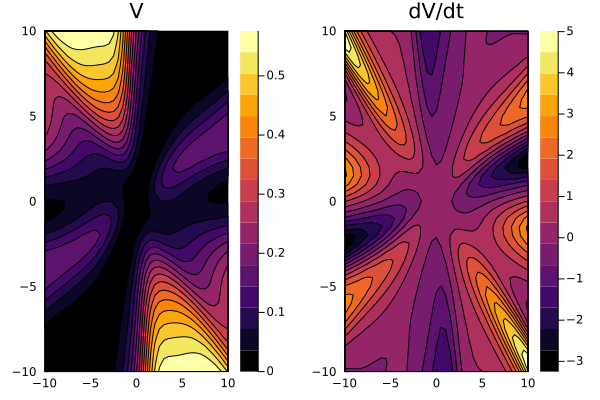

In [58]:
p1 = plot(xs, vs, V_predict, linetype=:contourf,title = "V");
p2 = plot(xs, vs, dVdt_predict, linetype=:contourf,title = "dV/dt");
plot(p1,p2)

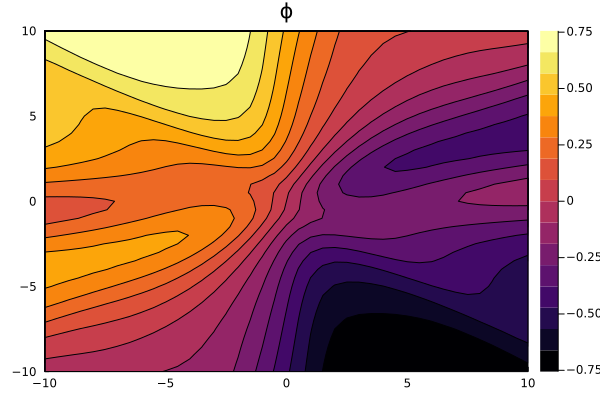

In [59]:
φ_predict = reshape([φ_fun(x,v) for x in xs for v in vs], (length(xs), length(vs)));
plot(xs, vs, φ_predict, linetype=:contourf,title = "ϕ")